# Importaciones

In [1]:
pip install "numpy>=1.23,<1.24" "seaborn<0.13"

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip list

Package                       Version
----------------------------- -------------------------
absl-py                       1.0.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
astor                         0.8.1
asttokens                     2.0.5
astunparse                    1.6.3
attrs                         21.4.0
backcall                      0.2.0
black                         21.12b0
bleach                        4.1.0
cachetools                    5.0.0
certifi                       2021.10.8
cffi                          1.15.0
charset-normalizer            2.0.10
click                         8.0.3
cloudpickle                   2.0.0
cmake-setuptools              0.1.3
cudf                          21.12.0a0+293.g0930f712e6
cugraph                       21.12.0a0+95.g4b8c1330
cuml                          21.12.0a0+116.g4ce5bd609
cupy-cuda115                  9.6.0
cycler                        0.11.0
Cython                        0.29.24
dask    

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

# Específicos para MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

2026-01-10 07:46:12.334793: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# Constantes

In [6]:
LOCAL_PATH = "/home/tomas.bolanos__espol.edu.ec"
DATASET_PATH = LOCAL_PATH + "/code"

DATASET_MEL_PATH = LOCAL_PATH + "/dataset/df_MEL.csv"

LOCAL_TRAIN_MEL_PATH = DATASET_PATH + "/dataset_mel_npy"
LOCAL_DEV_MEL_PATH = DATASET_PATH + "/dataset_mel_npy"

LOCAL_VAL_PATH = DATASET_PATH + "/dataset_mel_npy"
LOCAL_TEST_PATH = DATASET_PATH + "/dataset_mel_npy"

# Creación de dataframes

In [7]:
df_mel = pd.read_csv(DATASET_MEL_PATH)

In [8]:
df_mel.head()

,client_id,gender,accent_clean,votes,mel_path,original_path,segment_id,split
0,093936251af6b09c3c1b9602dd65fc76561c1fc68731ce...,male_masculine,espana,12,/home/tomas/Documentos/semestre7/IA/Proyecto/I...,common_voice_es_30101584.mp3,common_voice_es_30101584_p1.mp3,train
1,20e2f665fc2a7d62fe19aa656e8eeaee5a9ddb088df118...,male_masculine,espana,10,/home/tomas/Documentos/semestre7/IA/Proyecto/I...,common_voice_es_29833812.mp3,common_voice_es_29833812_p1.mp3,train
2,5b0af412cf3b35f8f25e068ebab679c42bd13721907a4a...,NaN,espana,9,/home/tomas/Documentos/semestre7/IA/Proyecto/I...,common_voice_es_30486920.mp3,common_voice_es_30486920_p1.mp3,train
3,05bb53f828160c852727d299a30ad3794b2903b1cf4e76...,female_feminine,espana,8,/home/tomas/Documentos/semestre7/IA/Proyecto/I...,common_voice_es_31168003.mp3,common_voice_es_31168003_p1.mp3,train
4,2652eec2bd39dfe5a39ce2414502db6ff8b3cc268aeff6...,female_feminine,espana,8,/home/tomas/Documentos/semestre7/IA/Proyecto/I...,common_voice_es_21950554.mp3,common_voice_es_21950554_p1.mp3,train


In [9]:
df_mel['path_npy'] = df_mel['mel_path'].apply(lambda x: os.path.basename(x).replace('.mp3', '.npy'))

In [10]:
df_train_mel = df_mel[df_mel['split'] == 'train'].copy()
df_dev_mel = df_mel[df_mel['split'] == 'dev'].copy()
df_dev = df_mel[df_mel['split'] == 'dev'].copy()
df_test = df_mel[df_mel['split'] == 'test'].copy()

print(f"DataFrame de entrenamiento (df_train_mel) cargado con {len(df_train_mel)} filas.")
print(f"DataFrame de desarrollo (df_dev_mel) cargado con {len(df_dev_mel)} filas.")
print(f"DataFrame de desarrollo (df_dev) cargado con {len(df_dev)} filas.")
print(f"DataFrame de prueba (df_test) cargado con {len(df_test)} filas.")

DataFrame de entrenamiento (df_train_mel) cargado con 33823 filas.
DataFrame de desarrollo (df_dev_mel) cargado con 4316 filas.
DataFrame de desarrollo (df_dev) cargado con 4316 filas.
DataFrame de prueba (df_test) cargado con 4455 filas.


# Verificación de muestras cargadas correctamente

Muestra 1: common_voice_es_30490449_p3.npy
   - Acento: espana | Label: espana
   - Dimensiones: (128, 253) | Max dB: 12.96

Muestra 2: common_voice_es_22976266_p2.npy
   - Acento: mexico | Label: mexico
   - Dimensiones: (128, 179) | Max dB: 12.31

Muestra 3: common_voice_es_18314969_p3.npy
   - Acento: espana | Label: espana
   - Dimensiones: (128, 286) | Max dB: 3.17

Muestra 4: common_voice_es_18533597_p1.npy
   - Acento: espana | Label: espana
   - Dimensiones: (128, 217) | Max dB: 22.59

Muestra 5: common_voice_es_19611141_p3.npy
   - Acento: andino | Label: andino
   - Dimensiones: (128, 261) | Max dB: 6.43



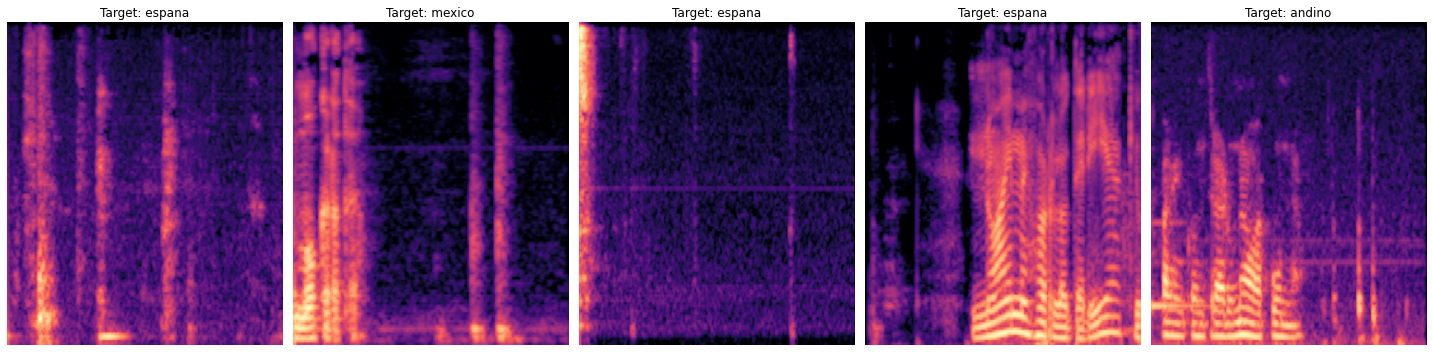

In [11]:
# 2. Seleccionamos 5 muestras aleatorias de tu dataframe
muestras_train = df_train_mel.sample(5)
muestras_dev = df_dev_mel.sample(5)

# 3. Configuramos la visualización
plt.figure(figsize=(20, 5))

for i, (idx, row) in enumerate(muestras_train.iterrows()):
    # Usar 'path_npy' para cargar el archivo .npy
    file_path = os.path.join(LOCAL_TRAIN_MEL_PATH, row['path_npy'])

    try:
        # Cargar el archivo .npy desde el disco local SSD
        mel_spec = np.load(file_path)

        # Mostrar info en consola
        print(f"Muestra {i+1}: {row['path_npy']}")
        print(f"   - Acento: {row['accent_clean']} | Label: {row['accent_clean']}")
        print(f"   - Dimensiones: {mel_spec.shape} | Max dB: {mel_spec.max():.2f}\n")

        # Graficar el espectrograma
        plt.subplot(1, 5, i + 1)
        plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='magma')
        plt.title(f"Target: {row['accent_clean']}")
        plt.axis('off') # Quitamos los ejes para ver mejor la "imagen"

    except FileNotFoundError:
        print(f"Error: No se encontró el archivo {file_path}")

plt.tight_layout()
plt.show()

# Generador de Datos 

In [40]:
from PIL import Image

class MelDataGenerator(Sequence):
    def __init__(self, df, ruta_base, batch_size=32, target_shape=(224, 224), shuffle=True, augment=False):
        self.df = df.copy().reset_index(drop=True)
        self.ruta_base = ruta_base
        self.batch_size = batch_size
        self.target_shape = target_shape
        self.shuffle = shuffle
        self.augment = augment
        self.mapping = {'andino': 0, 'mexico': 1, 'espana': 2}
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def _apply_augmentation(self, mel_rgb):
        # Desplazamientos sencillos con NumPy para evitar problemas de tensores
        shift = np.random.randint(-5, 5)
        mel_rgb = np.roll(mel_rgb, shift, axis=1)
        # Ruido gaussiano manual
        noise = np.random.normal(0, 2.0, mel_rgb.shape)
        mel_rgb = mel_rgb + noise
        return np.clip(mel_rgb, 0, 255)

    def _load_and_prepare(self, npy_name):
        ruta_archivo = os.path.join(self.ruta_base, npy_name)
        mel = np.load(ruta_archivo).astype(np.float32)

        # 1. Normalización Logarítmica (dB)
        mel = np.clip((mel + 80.0) / 80.0, 0.0, 1.0)
        
        # 2. Redimensionar usando Pillow (Evita el error de cv2 y Tensores)
        # Convertimos a imagen, redimensionamos y volvemos a array
        img = Image.fromarray(mel)
        img = img.resize(self.target_shape, Image.BILINEAR)
        mel_resized = np.array(img)
        
        # 3. Preparar 3 canales RGB
        mel_rgb = np.repeat(mel_resized[..., np.newaxis], 3, axis=-1)
        mel_rgb = mel_rgb * 255.0
        
        if self.augment:
            mel_rgb = self._apply_augmentation(mel_rgb)
            
        # 4. Preprocesamiento manual de MobileNetV2 (rango -1 a 1)
        mel_preprocessed = (mel_rgb / 127.5) - 1.0
        
        return mel_preprocessed

    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = [], []
        for _, row in batch_df.iterrows():
            X.append(self._load_and_prepare(row['path_npy']))
            y.append(self.mapping[row['accent_clean']])
        return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

## Inicialización de Generadores de Datos

In [41]:
# 1. Definimos las constantes a la medida de MobileNetV2 nativo
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32 # Bajamos el batch size porque 224x224 consume más memoria RAM/GPU

# 2. Generador de Entrenamiento (con Augment=True)
train_generator = MelDataGenerator(
    df=df_train_mel,
    ruta_base=LOCAL_TRAIN_MEL_PATH,
    batch_size=BATCH_SIZE,
    target_shape=IMG_SIZE,
    shuffle=True,
    augment=True      # <--- Activamos el aumento de datos para superar el 45%
)

In [42]:
# 3. Generador de Validación
val_generator = MelDataGenerator(
    df=df_dev_mel,
    ruta_base=LOCAL_DEV_MEL_PATH,
    batch_size=BATCH_SIZE,
    target_shape=IMG_SIZE,
    shuffle=False,
    augment=False
)

# 4. Generador de Test
test_generator = MelDataGenerator(
    df=df_test,
    ruta_base=LOCAL_TEST_PATH,
    batch_size=BATCH_SIZE,
    target_shape=IMG_SIZE,
    shuffle=False,
    augment=False
)

## Verificación de balanceo de muestras por acento

In [43]:
display(df_train_mel['accent_clean'].value_counts())
display(df_dev['accent_clean'].value_counts())
display(df_test['accent_clean'].value_counts())

espana    11353
mexico    11335
andino    11135
Name: accent_clean, dtype: int64

andino    1455
espana    1434
mexico    1427
Name: accent_clean, dtype: int64

andino    1608
mexico    1436
espana    1411
Name: accent_clean, dtype: int64

# Funciones Utils

In [44]:
def load_model(path):
  return models.load_model(path)

In [45]:
def save_model(model, path):
    model.save(path)
    print(f"✅ ¡Modelo guardado exitosamente en Drive!: {path}")

In [46]:
def evaluate_model_performance(model, val_generator, test_generator):
    """
    Evaluates the model on validation and test sets and prints the accuracy.

    Args:
        model: The trained Keras model.
        val_generator: The data generator for the validation set.
        test_generator: The data generator for the test set.
    """
    print("--- Evaluando en Set de VALIDACIÓN ---")
    val_results = model.evaluate(val_generator)

    print("\n--- Evaluando en Set de TEST (Prueba ciega) ---")
    test_results = model.evaluate(test_generator)

    print(f"\nPrecisión en Validación: {val_results[1]*100:.2f}%")
    print(f"Precisión en Test: {test_results[1]*100:.2f}%")

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_model_performance(model, test_generator, df_test):
    """
    Generates predictions, classification report, and confusion matrix for a given model.

    Args:
        model: The trained Keras model.
        test_generator: The data generator for the test set.
        df_test: The DataFrame containing the test set labels and metadata.
    """
    mapping = {'andino': 0, 'mexico': 1, 'espana': 2}
    print("Generando predicciones para el set de TEST...")
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    num_muestras_procesadas = len(y_pred)
    y_true_raw = df_test['accent_clean'].values[:num_muestras_procesadas]
    
    y_true = np.array([mapping[label] if isinstance(label, str) else label for label in y_true_raw])

    target_names = ['Andino (0)', 'México (1)', 'España (2)']

    print("\n" + "="*60)
    print("REPORTE DE CLASIFICACIÓN (Métricas por Acento)")
    print("="*60)
    print(classification_report(y_true, y_pred, target_names=target_names))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)

    plt.title('Matriz de Confusión: Identificación de Acentos (Set de Test)')
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Realidad (Etiqueta)')
    plt.show()

In [48]:
def plot_history(history):
    # Intentar obtener 'accuracy', si no existe, usar 'acc'
    acc = history.history.get('accuracy') or history.history.get('acc')
    val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 5))

    # Gráfico de Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo--', label='Precisión Entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Precisión Validación')
    plt.title('Evolución de la Precisión')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # Gráfico de Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo--', label='Pérdida Entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Pérdida Validación')
    plt.title('Evolución de la Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    plt.show()

# Modelo MobileNetV2



In [49]:
# 1. Cargar la base de MobileNetV2 pre-entrenada
# Cambiamos input_shape a 224 para coincidir con el generador y la resolución nativa
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3), # <--- Ajustado a la nueva resolución
    pooling='avg'
)

# 2. Congelamos la base (Transfer Learning puro)
base_model.trainable = False 

# 3. Construcción del modelo
model = models.Sequential([
    base_model,
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(0.5), # Subimos un poco para combatir el sesgo hacia "España"
    layers.Dense(3, activation='softmax')
])

# 4. Compilación
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               327936    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 771       
Total params: 2,587,715
Trainable params: 329,219
Non-trainable params: 2,258,496
_________________________________________________________________


In [50]:


# 1. Calculamos pesos para que la red no ignore los acentos menos frecuentes
y_labels = df_train_mel['accent_clean'].map({'andino': 0, 'mexico': 1, 'espana': 2}).values
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(weights))

print(f"📊 Pesos calculados: {class_weights}")

# 2. Verificamos que los callbacks estén listos (si no los has definido antes)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

📊 Pesos calculados: {0: 1.0125130968417901, 1: 0.994647845905014, 2: 0.9930708476467307}


In [51]:
print("🚀 Iniciando entrenamiento con MobileNetV2 (224x224) y Class Weights...")

history = model.fit(
    train_generator,
    epochs=15, 
    validation_data=val_generator,
    class_weight=class_weights, 
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

🚀 Iniciando entrenamiento con MobileNetV2 (224x224) y Class Weights...
Epoch 1/15


2026-01-10 07:52:35.906807: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2026-01-10 07:52:36.656494: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


1057/1057 [==============================] - 205s 194ms/step - loss: 1.5113 - acc: 0.3801 - val_loss: 1.5779 - val_acc: 0.3471
Epoch 2/15
1057/1057 [==============================] - 203s 192ms/step - loss: 1.2557 - acc: 0.4019 - val_loss: 1.3594 - val_acc: 0.3610
Epoch 3/15
1057/1057 [==============================] - 202s 192ms/step - loss: 1.1643 - acc: 0.4144 - val_loss: 1.3913 - val_acc: 0.3661
Epoch 4/15
1057/1057 [==============================] - 203s 192ms/step - loss: 1.1121 - acc: 0.4222 - val_loss: 1.2618 - val_acc: 0.3640
Epoch 5/15
1057/1057 [==============================] - 204s 193ms/step - loss: 1.0759 - acc: 0.4358 - val_loss: 1.1858 - val_acc: 0.3726
Epoch 6/15
1057/1057 [==============================] - 202s 191ms/step - loss: 1.0603 - acc: 0.4475 - val_loss: 1.3167 - val_acc: 0.3594
Epoch 7/15
1057/1057 [==============================] - 198s 187ms/step - loss: 1.0557 - acc: 0.4459 - val_loss: 1.1853 - val_acc: 0.3645
Epoch 8/15
1057/1057 [=======================

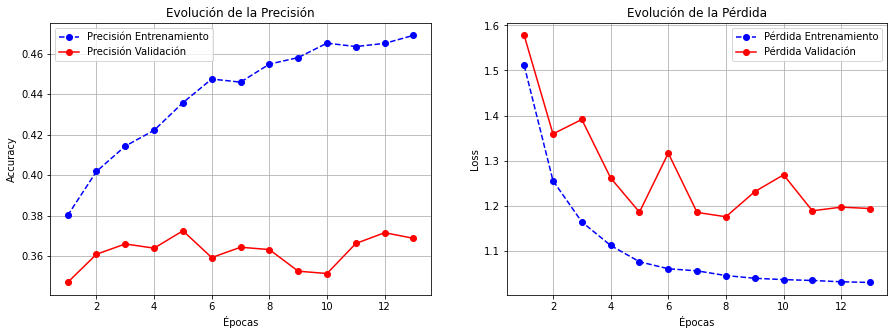

In [52]:
plot_history(history)

### Celda de Fine-Tuning (Fase 2)

In [66]:
# 1. Configuración de las capas (Descongelar)
base_model.trainable = True
for layer in base_model.layers[:-50]:
    layer.trainable = False

# 2. Re-compilación con LR bajo
model.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Definición de los nuevos Callbacks (TU CÓDIGO AQUÍ)
fine_tune_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,         # Más paciencia para el ajuste fino
    restore_best_weights=True,
    verbose=1
)

fine_tune_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

# 4. Ejecución del entrenamiento
print("🎯 Iniciando Fine-Tuning en la NVIDIA A100...")
history_fine = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[fine_tune_stop, fine_tune_lr], # Usamos los nuevos callbacks
    verbose=1
)

🎯 Iniciando Fine-Tuning en la NVIDIA A100...
Epoch 1/30
264/264 [==============================] - 42s 160ms/step - loss: 1.4257 - acc: 0.3949 - val_loss: 1.4408 - val_acc: 0.3532
Epoch 2/30
264/264 [==============================] - 36s 136ms/step - loss: 1.3509 - acc: 0.4182 - val_loss: 1.5578 - val_acc: 0.3485
Epoch 3/30
264/264 [==============================] - 35s 134ms/step - loss: 1.2981 - acc: 0.4340 - val_loss: 1.6256 - val_acc: 0.3409
Epoch 4/30
264/264 [==============================] - 37s 138ms/step - loss: 1.2406 - acc: 0.4557 - val_loss: 1.5551 - val_acc: 0.3390
Epoch 5/30
 33/264 [==>...........................] - ETA: 33s - loss: 1.5841 - acc: 0.3343
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
264/264 [==============================] - 36s 138ms/step - loss: 1.1984 - acc: 0.4679 - val_loss: 1.5841 - val_acc: 0.3343
Epoch 6/30
264/264 [==============================] - 36s 138ms/step - loss: 1.1615 - acc: 0.4823 - val_loss: 1.5457 - 

In [55]:
save_model(model, "/home/tomas.bolanos__espol.edu.ec/model/modelo_acentos_MobileNet_imagenet_v1.keras")
save_model(model, "/home/tomas.bolanos__espol.edu.ec/model/modelo_acentos_MobileNet_imagenet_v1.h5")

✅ ¡Modelo guardado exitosamente en Drive!: /home/tomas.bolanos__espol.edu.ec/model/modelo_acentos_MobileNet_imagenet_v1.keras
✅ ¡Modelo guardado exitosamente en Drive!: /home/tomas.bolanos__espol.edu.ec/model/modelo_acentos_MobileNet_imagenet_v1.h5


In [53]:
evaluate_model_performance(model, val_generator, test_generator)

--- Evaluando en Set de VALIDACIÓN ---
135/135 [==============================] - 7s 53ms/step - loss: 1.1757 - acc: 0.3633

--- Evaluando en Set de TEST (Prueba ciega) ---
140/140 [==============================] - 9s 62ms/step - loss: 1.2289 - acc: 0.3461

Precisión en Validación: 36.33%
Precisión en Test: 34.61%


Generando predicciones para el set de TEST...

REPORTE DE CLASIFICACIÓN (Métricas por Acento)
              precision    recall  f1-score   support

  Andino (0)       0.41      0.02      0.04      1608
  México (1)       0.47      0.15      0.22      1436
  España (2)       0.33      0.92      0.49      1411

    accuracy                           0.35      4455
   macro avg       0.40      0.36      0.25      4455
weighted avg       0.40      0.35      0.24      4455



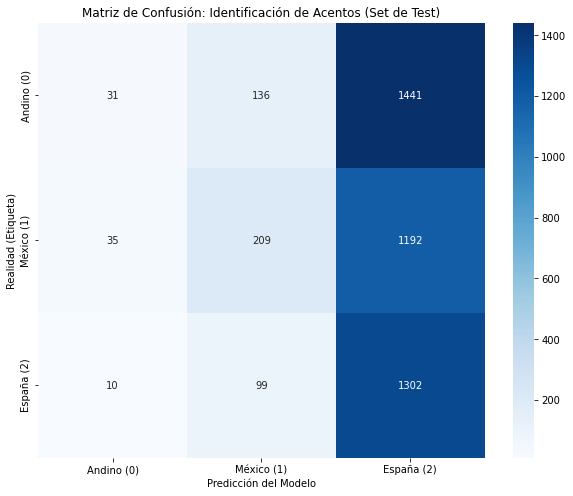

In [54]:
plot_model_performance(model, test_generator, df_test)

In [69]:
# Revisa las predicciones reales vs etiquetas
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
print(f"Predicciones únicas: {np.unique(y_pred, return_counts=True)}")

Predicciones únicas: (array([0, 1, 2]), array([ 795, 2143, 1414]))


In [70]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# 1. Definimos una pérdida más robusta contra el overfitting
# Nota: Si usas SparseCategoricalCrossentropy, el smoothing se aplica distinto. 
# Para simplificar, usemos el compilador estándar con un truco de regularización.

model.compile(
    optimizer=Adam(learning_rate=5e-5, decay=1e-6), # Añadimos decay
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# 2. Callbacks más estrictos
rescue_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

print("🛡️ Iniciando entrenamiento de rescate con Regularización...")
history_rescue = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=[rescue_stop, reduce_lr],
    verbose=1
)

🛡️ Iniciando entrenamiento de rescate con Regularización...
Epoch 1/40
264/264 [==============================] - 41s 155ms/step - loss: 1.3451 - acc: 0.4141 - val_loss: 1.6051 - val_acc: 0.3378
Epoch 2/40
264/264 [==============================] - 36s 137ms/step - loss: 1.1479 - acc: 0.4852 - val_loss: 1.4282 - val_acc: 0.3449
Epoch 3/40
264/264 [==============================] - 36s 137ms/step - loss: 1.0102 - acc: 0.5458 - val_loss: 1.4453 - val_acc: 0.3428
Epoch 4/40
264/264 [==============================] - 36s 137ms/step - loss: 0.8976 - acc: 0.5975 - val_loss: 1.4464 - val_acc: 0.3239
Epoch 5/40
 33/264 [==>...........................] - ETA: 35s - loss: 1.4450 - acc: 0.3518
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
264/264 [==============================] - 37s 139ms/step - loss: 0.7851 - acc: 0.6562 - val_loss: 1.4450 - val_acc: 0.3518
Epoch 6/40
264/264 [==============================] - 36s 137ms/step - loss: 0.6643 - acc: 0.7155 - val_

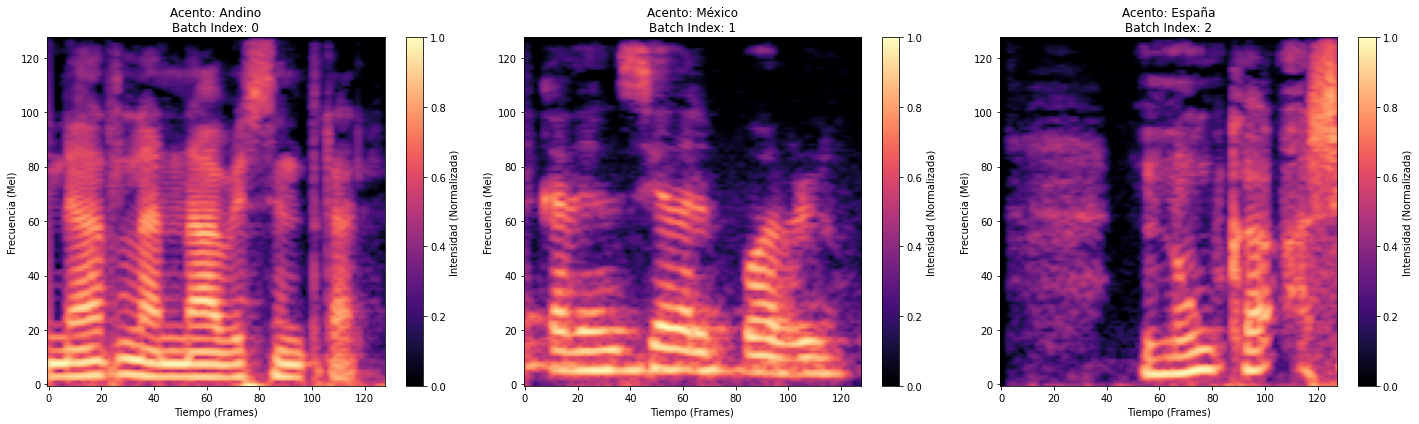

In [72]:
def visualizar_muestras_diagnostico(generator, n=3):
    # En Keras Sequence, accedemos al primer batch con el índice [0]
    X, y = generator[0] 
    mapping_inv = {0: 'Andino', 1: 'México', 2: 'España'}
    
    plt.figure(figsize=(20, 6))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        # Mostramos el espectrograma (primer canal)
        # Usamos la escala 'magma' o 'viridis' que resalta mejor las intensidades
        img = plt.imshow(X[i][:,:,0], aspect='auto', origin='lower', cmap='magma')
        plt.title(f"Acento: {mapping_inv[y[i]]}\nBatch Index: {i}")
        plt.colorbar(img, label="Intensidad (Normalizada)")
        plt.xlabel("Tiempo (Frames)")
        plt.ylabel("Frecuencia (Mel)")

    plt.tight_layout()
    plt.show()

# Llamada corregida
visualizar_muestras_diagnostico(train_generator)